## Import Libraries

In [12]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.exceptions import NotFittedError

## Ensure directory exists

In [13]:
os.makedirs("./trained_models/report_identify", exist_ok=True)

## Load dataset

In [14]:
with open("./datasets/datasets/report_generation_question.json", "r", encoding="utf-8") as f:
    data = json.load(f)

## Prepare DataFrame

In [15]:
rows = []
report_info_map = {}

for report_name, info in data[0].items():
    code = info["report_code"]
    report_info_map[code] = {
        "description": info.get("description", ""),
        "parameters_for_report_generate": info.get("parameters_for_report_generate", [])
    }
    for prompt in info.get("user_prompt", []):
        rows.append({"text": prompt, "label": code})

df = pd.DataFrame(rows)
print(f"Loaded {len(df)} training samples across {df['label'].nunique()} report types.")


Loaded 135 training samples across 9 report types.


## Split dataset

In [16]:
X = df["text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Vectorize text

In [17]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

## Train model

In [18]:
model = LogisticRegression(max_iter=500)
model.fit(X_train_vec, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,500
,multi_class,'deprecated'


## Evaluate

In [19]:
y_pred = model.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ Model Accuracy: {accuracy:.4f}\n")
print("Classification Report:\n")
print(classification_report(y_test, y_pred))


✅ Model Accuracy: 0.8148

Classification Report:

              precision    recall  f1-score   support

      CFR001       0.50      0.33      0.40         3
     CPBR001       0.60      1.00      0.75         3
      CSR001       0.33      0.33      0.33         3
      DSR001       1.00      1.00      1.00         3
      ISR001       1.00      1.00      1.00         3
      MPR001       1.00      1.00      1.00         3
      RPR001       1.00      0.67      0.80         3
      RRR001       1.00      1.00      1.00         3
      WSR001       1.00      1.00      1.00         3

    accuracy                           0.81        27
   macro avg       0.83      0.81      0.81        27
weighted avg       0.83      0.81      0.81        27



## Save model, vectorizer, and report info

In [20]:
joblib.dump(model, "./trained_models/report_identify/report_model.pkl")
joblib.dump(vectorizer, "./trained_models/report_identify/vectorizer.pkl")
joblib.dump(report_info_map, "./trained_models/report_identify/report_info_map.pkl")
print("✅ Saved model, vectorizer, and report info as .pkl files.")

✅ Saved model, vectorizer, and report info as .pkl files.


## Example usage

In [21]:
try:
    model = joblib.load("./trained_models/report_identify/report_model.pkl")
    vectorizer = joblib.load("./trained_models/report_identify/vectorizer.pkl")
    report_info_map = joblib.load("./trained_models/report_identify/report_info_map.pkl")

    if not hasattr(vectorizer, "vocabulary_"):
        raise NotFittedError("Vectorizer is not fitted. Refit before using transform().")

    def predict_report(user_question: str):
        vec = vectorizer.transform([user_question])
        report_code = model.predict(vec)[0]
        report_details = report_info_map.get(report_code, {})
        return {
            "report_code": report_code,
            "description": report_details.get("description", ""),
            "parameters_for_report_generate": report_details.get("parameters_for_report_generate", []),
        }

    test_question = "Can you generate a daily sales report?"
    prediction = predict_report(test_question)
    print("\n🧠 Example Prediction:")
    print(prediction)

except NotFittedError as e:
    print("❌ Vectorizer not fitted:", str(e))


🧠 Example Prediction:
{'report_code': 'DSR001', 'description': 'Generates a summary of sales for a specific day, including top-selling fish items and sales by category.', 'parameters_for_report_generate': ['Date']}


In [22]:
user_question = "Can you generate a daily sales report?"
predicted_report = predict_report(user_question)
print(predicted_report)

{'report_code': 'DSR001', 'description': 'Generates a summary of sales for a specific day, including top-selling fish items and sales by category.', 'parameters_for_report_generate': ['Date']}


## Accuracy Check

In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.8148
Classification Report:
              precision    recall  f1-score   support

      CFR001       0.50      0.33      0.40         3
     CPBR001       0.60      1.00      0.75         3
      CSR001       0.33      0.33      0.33         3
      DSR001       1.00      1.00      1.00         3
      ISR001       1.00      1.00      1.00         3
      MPR001       1.00      1.00      1.00         3
      RPR001       1.00      0.67      0.80         3
      RRR001       1.00      1.00      1.00         3
      WSR001       1.00      1.00      1.00         3

    accuracy                           0.81        27
   macro avg       0.83      0.81      0.81        27
weighted avg       0.83      0.81      0.81        27



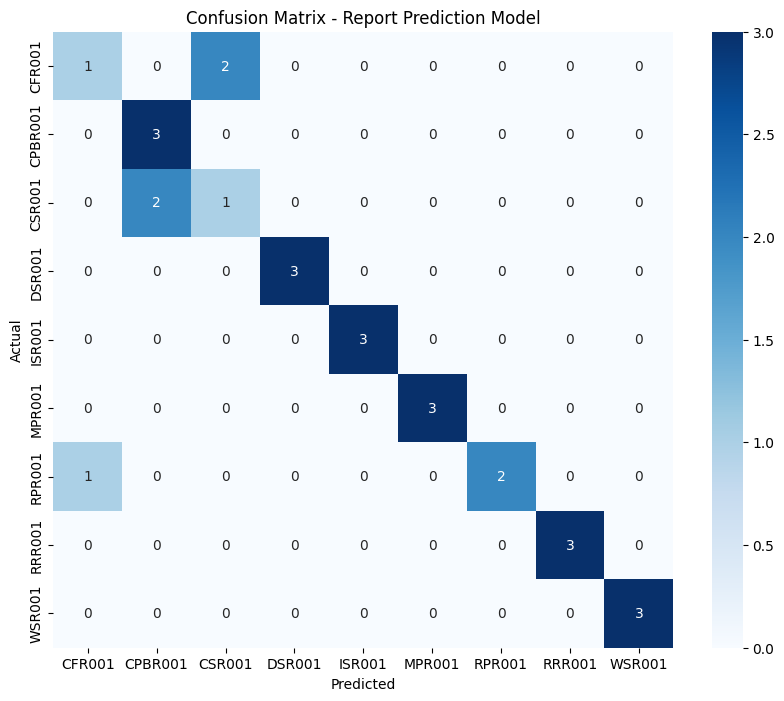

In [24]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=model.classes_,
    yticklabels=model.classes_,
    cmap="Blues",
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Report Prediction Model")
plt.show()